# Deep and Reinforcement Learning 2024/2025 (M.IA003), FEUP/FCUP

## Deep Learning Project 
## **Develop deep learning discriminative and generative models, applied to the context of “deep fakes”**

work done by:
- Michal Kowalski up
- Pedro Pereira up
- Pedro Azevedo up201905966

## 1.1) Import Necessary

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import glob
from _model import *
from tensorflow.keras.models import load_model
import json


print(tf.config.list_physical_devices('GPU'))
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

E0000 00:00:1743176061.341639   16937 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743176061.344506   16937 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]


In [5]:
# Define dataset directories
data_dir = "data"
real_dir = os.path.join(data_dir, "real")
fake_dir = os.path.join(data_dir, "fake")

## 1.2) Basic EDA

In [6]:
from _eda import base_stats

base_stats(real_dir, fake_dir)


Real Images Summary:
Total images: 30000
Formats: Counter({'JPEG': 28952, 'PNG': 1005, 'GIF': 36, 'MPO': 7})
Color Modes: Counter({'RGB': 26445, 'L': 2840, 'RGBA': 664, 'P': 40, 'LA': 11})
Top 5 Sizes: [((440, 660), 1469), ((440, 587), 959), ((440, 293), 688), ((440, 330), 579), ((440, 440), 272)]

Fake Images Summary:
Total images: 30000
Formats: Counter({'JPEG': 30000})
Color Modes: Counter({'RGB': 30000})
Top 5 Sizes: [((512, 512), 30000)]


## 1.3) File Standardization 

In [7]:
from _preprocess import standardize_files

standardize_files('data/real', (64, 64), '64')
standardize_files('data/fake', (64, 64), '64')

data/real/808_1899-08-13_1955.jpg
data/real/10000217_1981-05-05_2009.jpg
data/real/10000548_1925-04-04_1964.jpg
data/real/100012_1948-07-03_2008.jpg
data/real/10001965_1930-05-23_1961.jpg
data/real/10002116_1971-05-31_2012.jpg
data/real/10002702_1960-11-09_2012.jpg
data/real/100039_1904-12-07_1982.jpg
data/real/10004122_1982-03-17_2011.jpg
data/real/10004299_1908-08-19_1950.jpg
data/real/10005947_1981-04-07_2006.jpg
data/real/10007577_1988-06-16_2007.jpg
data/real/100097_1968-03-23_2010.jpg
data/real/1001231_1981-01-30_2014.jpg
data/real/10012532_1983-03-30_2011.jpg
data/real/1001319_1920-11-30_1950.jpg
data/real/100131_1926-09-06_1986.jpg
data/real/1001441_1978-06-24_2005.jpg
data/real/10014795_1968-10-11_2010.jpg
data/real/100156_1920-04-07_1988.jpg
data/real/10016074_1987-07-27_2012.jpg
data/real/10017169_1985-01-20_2009.jpg
data/real/10017464_1973-08-03_2007.jpg
data/real/10019295_1978-04-09_2009.jpg
data/real/10024005_1955-12-24_2012.jpg
data/real/1002427_1966-05-28_2000.jpg
data/

In [8]:
real_dir = os.path.join(data_dir, "real_normalized_64")
fake_dir = os.path.join(data_dir, "fake_normalized_64")
base_stats(real_dir, fake_dir)


Real Images Summary:
Total images: 30000
Formats: Counter({'JPEG': 30000})
Color Modes: Counter({'RGB': 30000})
Top 5 Sizes: [((64, 64), 30000)]

Fake Images Summary:
Total images: 30000
Formats: Counter({'JPEG': 30000})
Color Modes: Counter({'RGB': 30000})
Top 5 Sizes: [((64, 64), 30000)]


## 1.4) Baseline

In [9]:
gan = build_gan(d_lr=1e-5, label_smoothing=True)

/mnt/c/Users/pedro azevedo/Documents/MIA/ACPR/Discriminative-Generative-Models-ACPR-/py_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/mnt/c/Users/pedro azevedo/Documents/MIA/ACPR/Discriminative-Generative-Models-ACPR-/py_venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
gan.summary()

Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │     1,110,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,110,752 (4.24 MB)

 Trainable params: 1,094,176 (4.17 MB)

 Non-trainable params: 16,576 (64.75 KB)

In [ ]:

batch_size = 256
# Get all image file paths

def save_paths(path_list, fname):
    with open(fname, "w") as final:
	    json.dump(path_list, final)

# Define the preprocessing function
def load_and_preprocess(image_path):
    # Read the image file
    image = tf.io.read_file(image_path)

    # Decode the JPEG image
    image = tf.image.decode_jpeg(image, channels=3)

    # Normalize the image to the range [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0

    return image

def load_paths(train_file, test_file):
    with open(train_file, "r") as train:
	    train_paths = json.load(train)
    with open(test_file, "r") as test:
	    test_paths = json.load(test)
    return train_paths, test_paths

# image_paths = glob.glob("./data/real_normalized_64/*.jpg")
# train_paths = image_paths[:25000]
# test_paths = image_paths[25000:]
# save_paths(train_paths, 'train.json')
# save_paths(test_paths, 'test.json')

train_paths, test_paths = load_paths('./train.json', './test.json')

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size//2, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [14]:
gan.discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_94 (Activation)      │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 19, D Loss: 0.4858025312423706, G Loss: 2.662325620651245


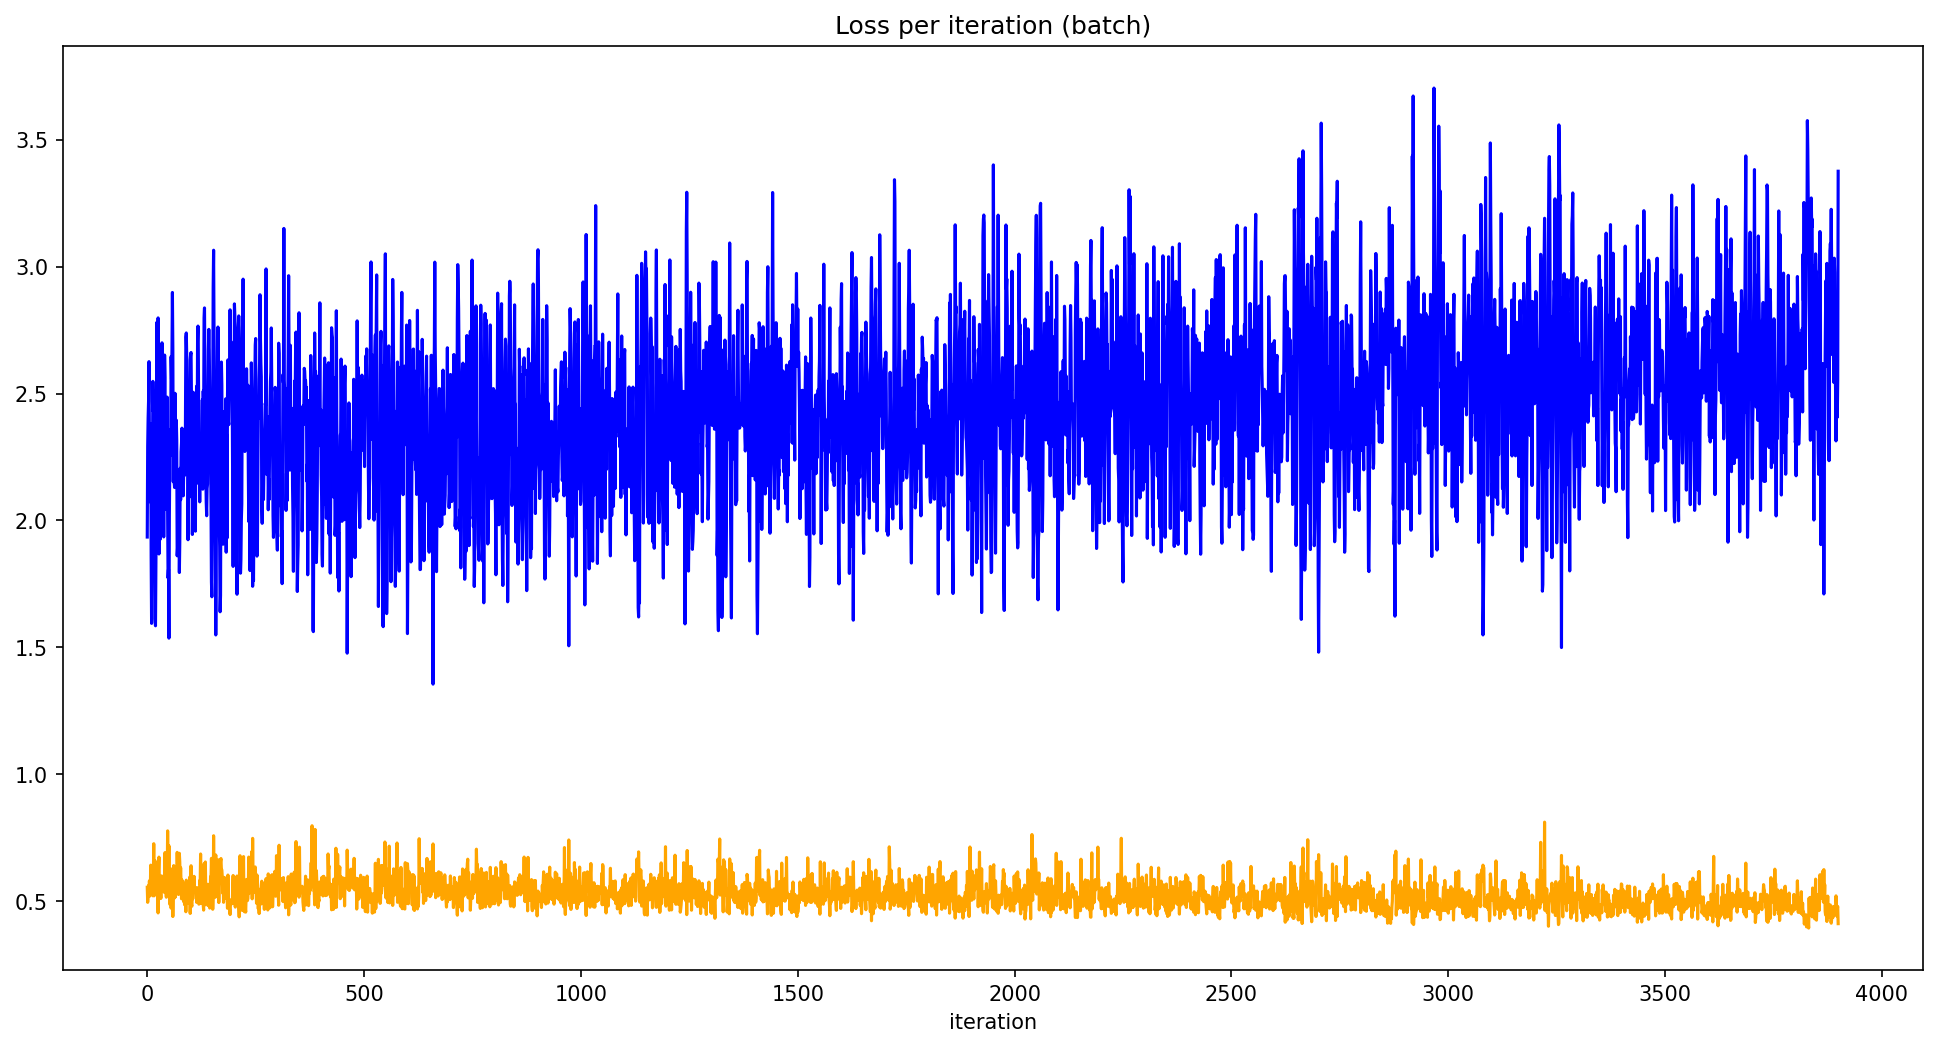

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [32]:
d_losses, e_losses = train_gan(gan, dataset, epochs=20, batch_size=batch_size)

In [31]:
gan.save('ls_dlr.keras')

In [20]:
final_d_losses = [float(x) for x in d_losses]
final_g_losses = [float(x) for x in e_losses]
with open('d_losses.json', "w") as f:
    json.dump(final_d_losses, f)

with open('g_losses.json', "w") as f:
    json.dump(final_g_losses, f)

# 1.5) Load Model

In [29]:
gan = keras.models.load_model("ls_dlr.keras", custom_objects={"GAN": GAN})

In [22]:
gan.summary()

Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │     1,110,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (128, 1, 1, 1)         │     2,767,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,878,112 (14.79 MB)

 Trainable params: 3,859,744 (14.72 MB)

 Non-trainable params: 18,368 (71.75 KB)

In [25]:
gan.generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,110,752 (4.24 MB)

 Trainable params: 1,094,176 (4.17 MB)

 Non-trainable params: 16,576 (64.75 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


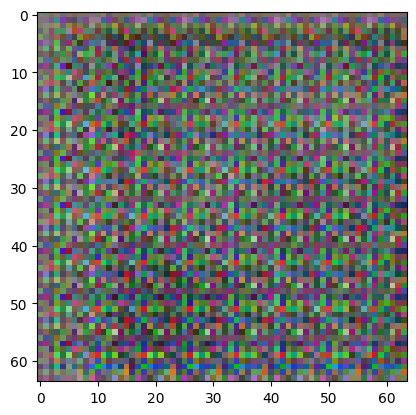

In [26]:
def generate_image(generator):
    noise = np.random.normal(0, 1, (1, LATENT_DIM))
    gen_images = generator.predict(noise)
    gen_images = (gen_images + 1) / 2  # Rescale images to [0,1]
    plt.imshow(gen_images[0])
    plt.show()

generate_image(gan.generator)


In [35]:
from _fid import *

noise = np.random.normal(0, 1, (batch_size//2, LATENT_DIM))
gen_images = gan.generator.predict(noise)
real_images = dataset.take(1)

real_images = next(iter(dataset.take(1)))[0].numpy()

# Ensure correct dtype for skimage
real_images = real_images.astype(np.float32)

gen_images = img_scaler(gen_images, (75,75,3))
real_images = img_scaler(real_images, (75,75,3))

calculate_fid(inception_model, gen_images, real_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


np.float64(1185.9742736307217)

In [28]:
d_losses, e_losses = train_gan(dataset, d, g, do, go, epochs=200, batch_size=batch_size)

NameError: name 'd' is not defined

test

In [ ]:
# Create a discriminator model
discriminator = build_discriminator()

In [34]:
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_99 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_95 (Activation)      │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 256
epochs = 10

image_real_train_paths = glob.glob("./data/real_normalized_64/*.jpg")
image_fake_train_paths = glob.glob("./data/fake_normalized_64/*.jpg")
save_paths(train_paths, 'real_train_paths.json')
save_paths(test_paths, 'fake_train_paths.json')

real_train_paths, fake_train_paths = load_paths('./real_train_paths.json', './fake_train_paths.json')

real_dataset = tf.data.Dataset.from_tensor_slices(real_train_paths)
real_dataset = real_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
real_dataset = real_dataset.shuffle(buffer_size=1000).batch(batch_size//2, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

fake_dataset = tf.data.Dataset.from_tensor_slices(fake_train_paths)
fake_dataset = fake_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
fake_dataset = fake_dataset.shuffle(buffer_size=1000).batch(batch_size//2, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


train_discriminator(discriminator, real_dataset, fake_dataset, epochs=epochs, debug_loss=True, batch_size=batch_size, label_smoothing=True)